## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ax.service.managed_loop import optimize
from statistics import mean 
from pykalman import KalmanFilter

import logging
from ax.utils.common.logger import get_logger
"""
Only show log messages of ERROR while testing.

Ax prints a lot of INFO logs that are not relevant for unit tests.
"""
logger = get_logger(__name__, level=logging.ERROR)
# Parent handlers are shared, so setting the level this
# way applies it to all Ax loggers.
if logger.parent is not None and hasattr(logger.parent, "handlers"):
    logger.parent.handlers[0].setLevel(logging.ERROR)

## Dataset loading and preprocessing

In [2]:
# Load and preprocess data
data = pd.read_csv('OCULUS_dataset.csv')

# Handle NaN values by replacing them with the mean
data.fillna(data.mean(), inplace=True)

features = data.drop(["game_section", "stress_label", "subject"], axis=1)
labels = data["stress_label"]

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Convert to tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

## LSTM model's initialization

In [3]:
# Define the LSTM model
class StressLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate_1, dropout_rate_2, dropout_rate_fc):
        super(StressLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate_1)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate_2)
        self.dropout = nn.Dropout(dropout_rate_fc)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)  
        out = self.dropout(out)
        out = self.fc(out).squeeze(-1)
        return out

In [4]:
# Define the hyperparameter space
parameters=[
    {"name": "lr", "type": "range", "bounds": [1e-6, 1e-3], "log_scale": True, "value_type": "float"},
    {"name": "hidden_size", "type": "range", "bounds": [32, 256], "value_type": "int"},
    {"name": "num_layers", "type": "range", "bounds": [2, 3], "value_type": "int"},
    {"name": "num_epochs", "type": "range", "bounds": [10, 100], "value_type": "int"},
    {"name": "dropout_rate_1", "type": "range", "bounds": [0.0, 0.7], "value_type": "float"},
    {"name": "dropout_rate_2", "type": "range", "bounds": [0.0, 0.7], "value_type": "float"},
    {"name": "dropout_rate_fc", "type": "range", "bounds": [0.0, 0.7], "value_type": "float"},
    {"name": "weight_decay", "type": "range", "bounds": [1e-6, 1], "value_type": "float"}, # weight decay for L2 optimization
    {"name": "batch_size", "type": "range", "bounds": [1, 100], "value_type": "int"}
]

# Loss functions
criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()

In [5]:
# Optimization on the entire dataset
def evaluate_full_dataset(parameters, features, labels):    
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, shuffle=False)

    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=int(parameters['batch_size']), shuffle=False)

    model = StressLSTM(input_size=features.shape[1], 
                       hidden_size=int(parameters['hidden_size']), 
                       num_layers=int(parameters['num_layers']), 
                       dropout_rate_1=parameters['dropout_rate_1'], 
                       dropout_rate_2=parameters['dropout_rate_2'], 
                       dropout_rate_fc=parameters['dropout_rate_fc'])

    optimizer = optim.Adam(model.parameters(), lr=parameters['lr'], weight_decay=parameters['weight_decay'])

    # Training
    for epoch in range(int(parameters['num_epochs'])):
        for batch_features, batch_labels in train_dataloader:
            model.train()
            outputs = model(batch_features.unsqueeze(0))
            loss = criterion(outputs.view(-1), batch_labels.view(-1))
            mae = mae_criterion(outputs.view(-1), batch_labels.view(-1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_val.unsqueeze(0))
        loss = criterion(outputs, y_val.unsqueeze(0))
        mae = mae_criterion(outputs, y_val.unsqueeze(0))

    return loss.item(), mae.item()

def evaluate_with_objective(parameters):
    mse_loss, mae_loss = evaluate_full_dataset(parameters, features_tensor, labels_tensor)
    return (mse_loss + mae_loss) / 2

# Bayesian optimization on the entire dataset
best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=evaluate_with_objective,  
    objective_name='loss'
)

print(best_parameters)

{'lr': 6.57433407215419e-06, 'hidden_size': 75, 'num_layers': 2, 'num_epochs': 27, 'dropout_rate_1': 0.5205495281144976, 'dropout_rate_2': 0.048584194760769604, 'dropout_rate_fc': 0.44314455613493914, 'weight_decay': 0.9791985483238576, 'batch_size': 66}


In [6]:
input_size = features.shape[1]
output_size = 1
learning_rate = best_parameters['lr']
hidden_size = int(best_parameters['hidden_size'])
num_layers = int(best_parameters['num_layers'])
num_epochs = int(best_parameters['num_epochs'])
dropout_rate_1 = best_parameters['dropout_rate_1']
dropout_rate_2 = best_parameters['dropout_rate_2']
dropout_rate_fc = best_parameters['dropout_rate_fc']
weight_decay = best_parameters['weight_decay']
batch_size = int(best_parameters['batch_size'])

## Training and evaluation

In [7]:
# Number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Kalman filter's initialization
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1) 

def calculate_loss_and_mae(model, criterion, mae_criterion, inputs, targets, use_kalman_filter=False):
    outputs = model(inputs.unsqueeze(0))
    if use_kalman_filter:
        (filtered_state_means, filtered_state_covariances) = kf.filter(outputs.detach().numpy()) # conversion in numpy arrays
        outputs = torch.tensor(filtered_state_means, dtype=torch.float32).view(1, -1) # back to pytorch
    loss = criterion(outputs, targets.unsqueeze(0))
    mae = mae_criterion(outputs, targets.unsqueeze(0))
    return loss, mae

In [11]:
# Group by subject for applying tss on each subject
grouped = data.groupby('subject')

# Lists to collect training and testing data from each subject
all_X_train, all_y_train, all_X_val, all_y_val, all_X_test, all_y_test = [], [], [], [], [], []
# Time series split on each group
for name, group in grouped:
    features = group.drop(["game_section", "stress_label", "subject"], axis=1)
    labels = group["stress_label"]

    # Normalization
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Tensors
    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels.values, dtype=torch.float32)
    
    for train_index, test_index in tscv.split(features_tensor):
        # Splitting data into train, val and test
        X_train_val, X_test = features_tensor[train_index], features_tensor[test_index]
        y_train_val, y_test = labels_tensor[train_index], labels_tensor[test_index]
        
        # Validation set
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)
        
        # Collect the training and testing data from each subject
        all_X_train.append(X_train)
        all_y_train.append(y_train)
        all_X_val.append(X_val)
        all_y_val.append(y_val)
        all_X_test.append(X_test)
        all_y_test.append(y_test)
    
# Concatenate the training and testing data from each subject
X_train = torch.cat(all_X_train)
y_train = torch.cat(all_y_train)
X_val = torch.cat(all_X_val)
y_val = torch.cat(all_y_val)
X_test = torch.cat(all_X_test)
y_test = torch.cat(all_y_test)

## Results

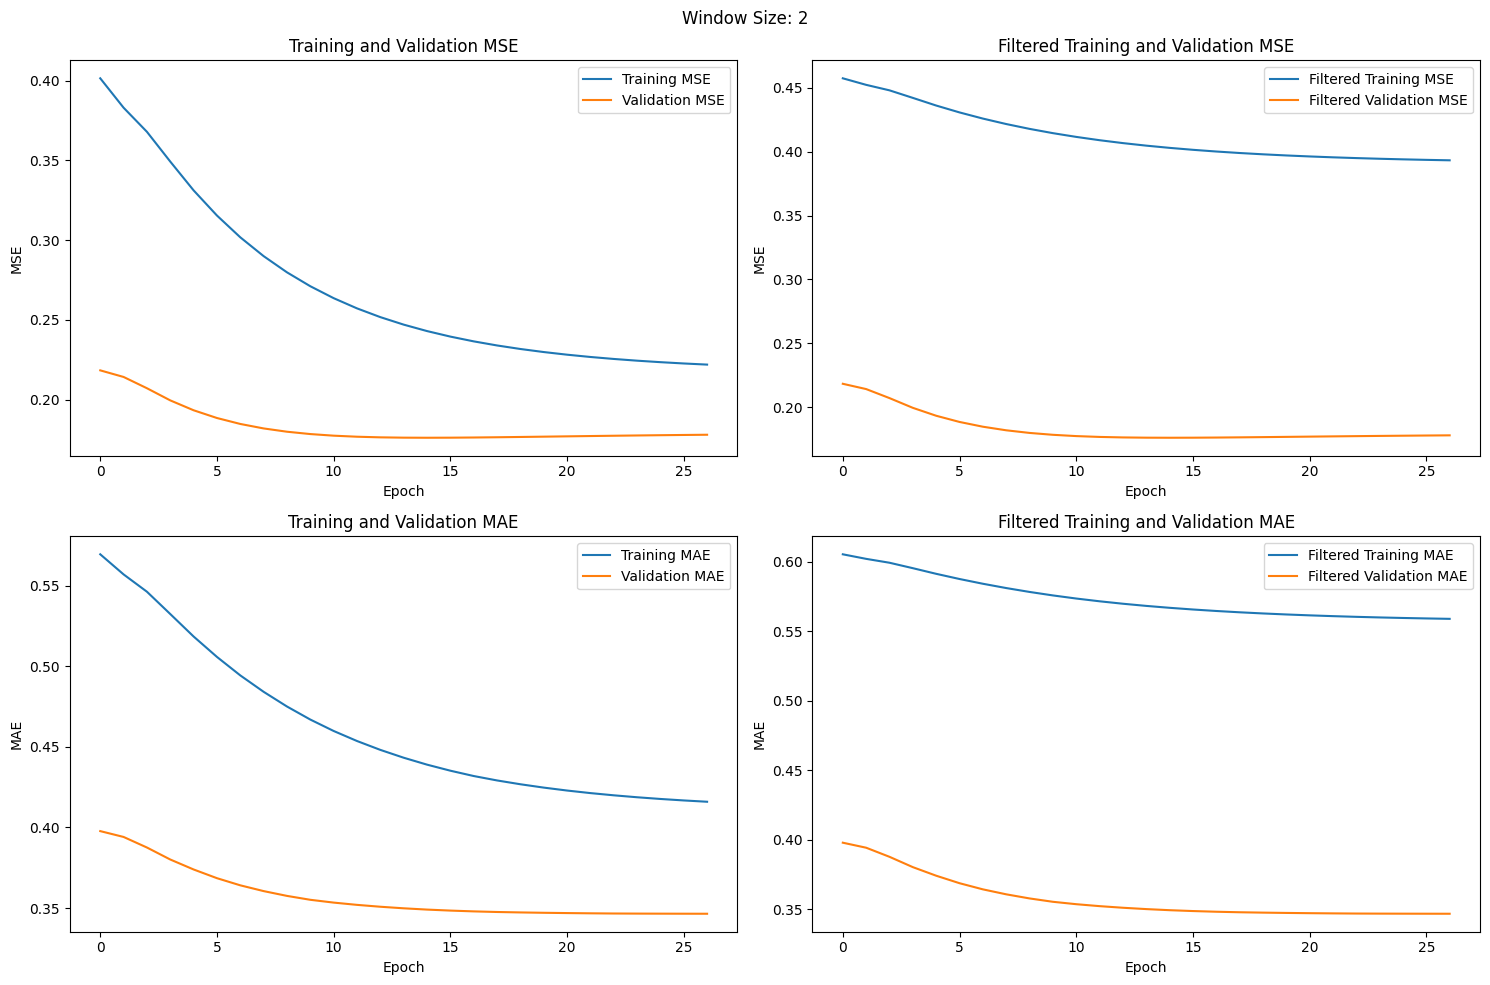

Average test MSE : 0.19940265626819045
Average test MAE : 0.36609977925265275
Average filtered test MSE : 0.19946026581305046
Average filtered test MAE : 0.36618597198415687


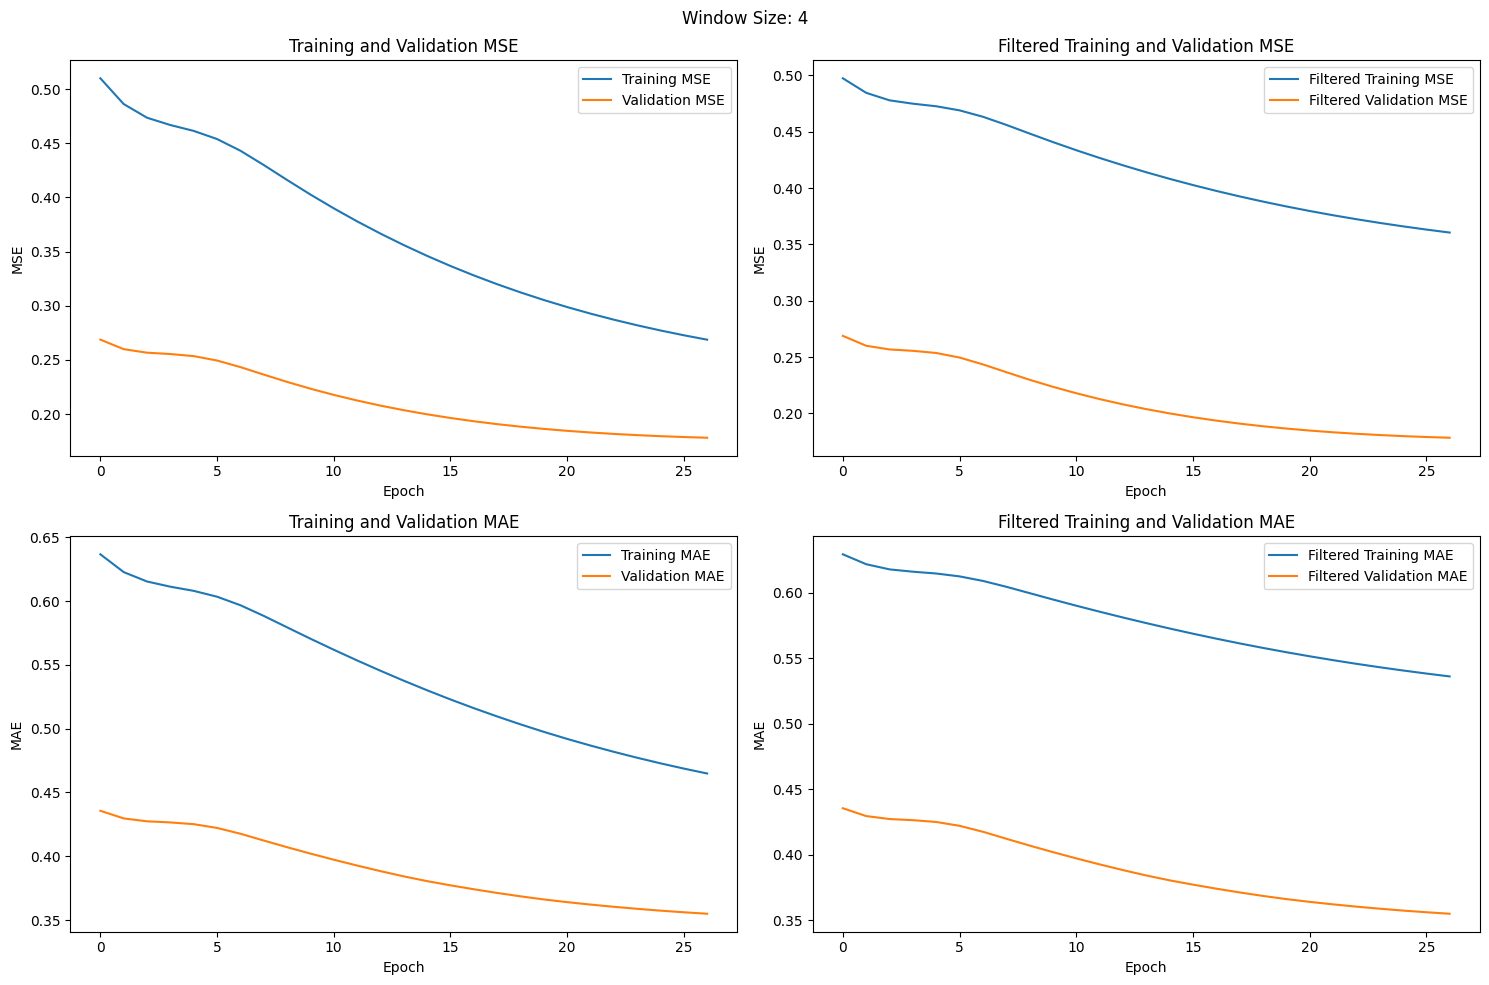

Average test MSE : 0.20913143621550667
Average test MAE : 0.3795609838432736
Average filtered test MSE : 0.20917992956108517
Average filtered test MAE : 0.37962864946436


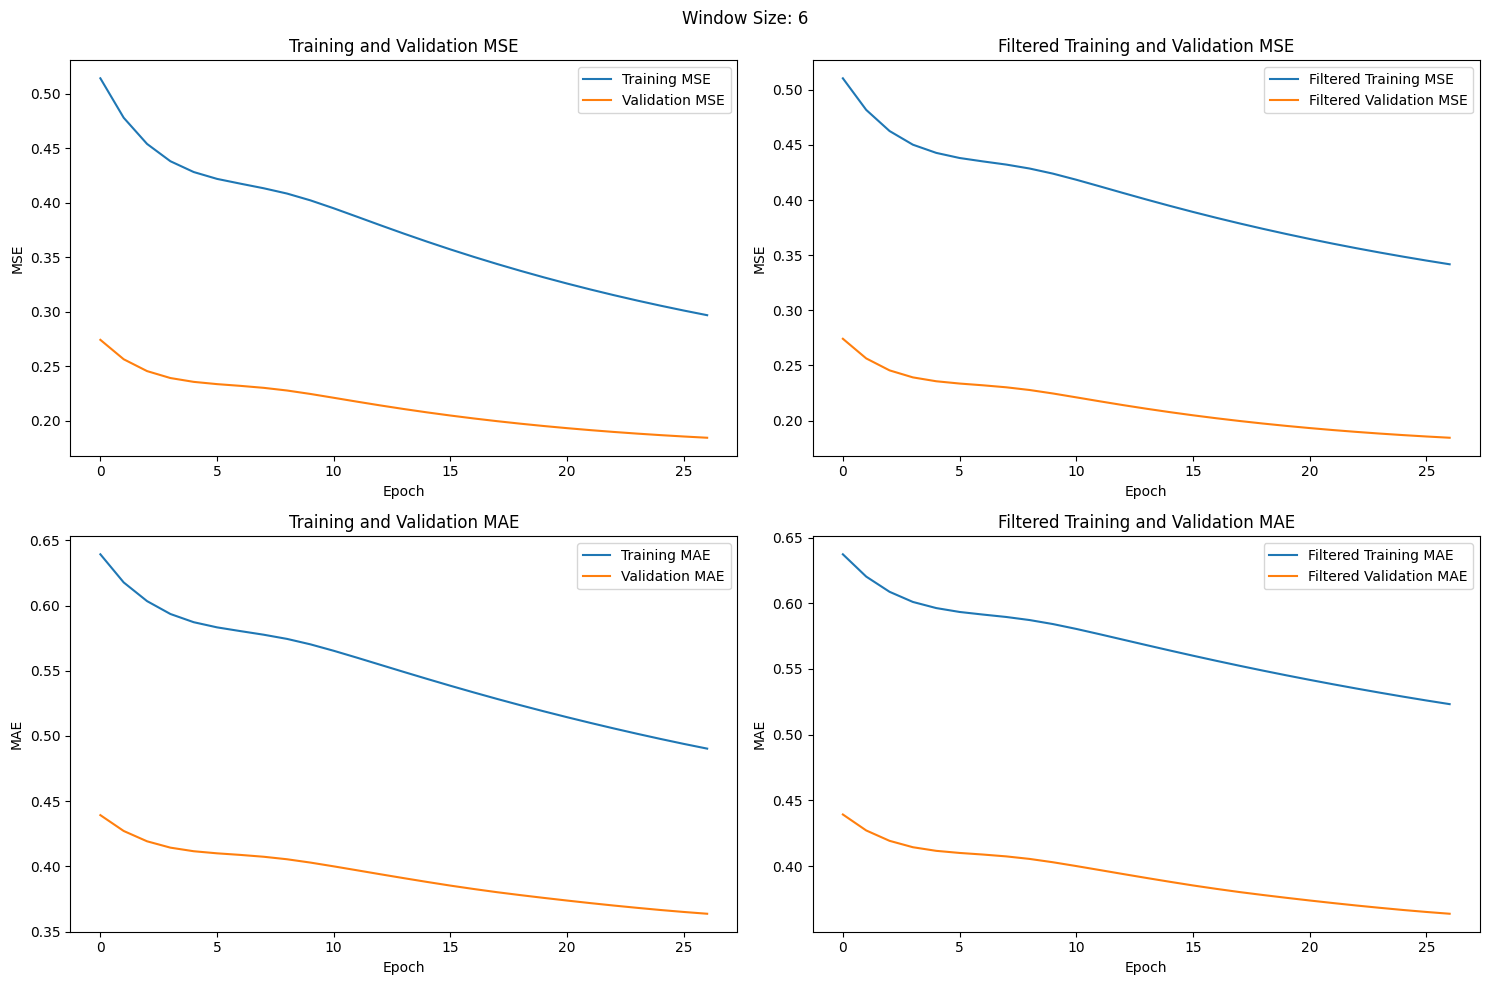

Average test MSE : 0.2126045909560757
Average test MAE : 0.3848501675658756
Average filtered test MSE : 0.21264712181356218
Average filtered test MAE : 0.3849070605672436


In [12]:
# Candidate window sizes
window_sizes = [2, 4, 6]

# Lists for each fold's losses
all_train_losses, all_val_losses, all_train_maes, all_val_maes, losses, maes = [], [], [], [], [], []
all_filtered_train_losses, all_filtered_val_losses, all_filtered_train_maes, all_filtered_val_maes, filtered_losses, filtered_maes = [], [], [], [], [], []

for window_size in window_sizes:
    if len(X_train) < window_size or len(y_train) < window_size:
        # Skip if data are less than the number required for a complete window
        continue
    
    # DataLoader for online learning
    # TensorDataset from data, ensuring that each batch has the same number of windows
    train_dataset = TensorDataset(X_train[:len(X_train)//window_size*window_size], y_train[:len(y_train)//window_size*window_size])
    # DataLoader from TensorDataset
    train_dataloader = DataLoader(train_dataset, batch_size=window_size, shuffle=False)

    # Model's instance with best params
    model = StressLSTM(input_size, hidden_size, num_layers, dropout_rate_1, dropout_rate_2, dropout_rate_fc)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Fit the Kalman Filter to the training data
    model.eval()
    with torch.no_grad():
        training_outputs = model(X_train.unsqueeze(0))
        kf.em(training_outputs.detach().numpy(), n_iter=10)

    train_losses, val_losses, train_maes, val_maes = [], [], [], []
    filtered_train_losses, filtered_val_losses, filtered_train_maes, filtered_val_maes = [], [], [], []
    # Training
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_mae = 0.0
        running_filtered_loss = 0.0
        running_filtered_mae = 0.0
        num_batches = 0
        
        for batch_features, batch_labels in train_dataloader:
            model.train()
            loss, mae = calculate_loss_and_mae(model, criterion, mae_criterion, batch_features, batch_labels)
            filtered_loss, filtered_mae = calculate_loss_and_mae(model, criterion, mae_criterion, batch_features, batch_labels, use_kalman_filter=True)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            running_mae += mae.item()
            running_filtered_loss += filtered_loss.item()
            running_filtered_mae += filtered_mae.item()
            num_batches += 1
        
        average_train_loss = running_loss / num_batches
        average_train_mae = running_mae / num_batches
        average_filtered_loss = running_filtered_loss / num_batches
        average_filtered_mae = running_filtered_mae / num_batches
        train_losses.append(average_train_loss)
        train_maes.append(average_train_mae)
        filtered_train_losses.append(average_filtered_loss)
        filtered_train_maes.append(average_filtered_mae)

        # Evaluation
        model.eval()
        with torch.no_grad():
            val_loss, val_mae = calculate_loss_and_mae(model, criterion, mae_criterion, X_val, y_val)
            val_filtered_loss, val_filtered_mae = calculate_loss_and_mae(model, criterion, mae_criterion, X_val, y_val, use_kalman_filter=True)
        
        val_losses.append(val_loss.item())
        val_maes.append(val_mae.item())
        filtered_val_losses.append(val_filtered_loss.item())
        filtered_val_maes.append(val_filtered_mae.item())
        
        # Test
        model.eval()
        with torch.no_grad():
            test_loss, test_mae = calculate_loss_and_mae(model, criterion, mae_criterion, X_test, y_test)
            test_filtered_loss, test_filtered_mae = calculate_loss_and_mae(model, criterion, mae_criterion, X_test, y_test, use_kalman_filter=True)
        
        losses.append(test_loss.item())
        maes.append(test_mae.item())
        filtered_losses.append(test_filtered_loss.item())
        filtered_maes.append(test_filtered_mae.item())
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training and validation MSE
    axs[0, 0].plot(train_losses, label='Training MSE')
    axs[0, 0].plot(val_losses, label='Validation MSE')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].legend()
    axs[0, 0].set_title('Training and Validation MSE')

    # Plot filtered training and validation MSE
    axs[0, 1].plot(filtered_train_losses, label='Filtered Training MSE')
    axs[0, 1].plot(filtered_val_losses, label='Filtered Validation MSE')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('MSE')
    axs[0, 1].legend()
    axs[0, 1].set_title('Filtered Training and Validation MSE')

    # Plot training and validation MAE
    axs[1, 0].plot(train_maes, label='Training MAE')
    axs[1, 0].plot(val_maes, label='Validation MAE')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('MAE')
    axs[1, 0].legend()
    axs[1, 0].set_title('Training and Validation MAE')

    # Plot filtered training and validation MAE
    axs[1, 1].plot(filtered_train_maes, label='Filtered Training MAE')
    axs[1, 1].plot(filtered_val_maes, label='Filtered Validation MAE')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('MAE')
    axs[1, 1].legend()
    axs[1, 1].set_title('Filtered Training and Validation MAE')

    # Title
    fig.suptitle(f'Window Size: {window_size}')

    plt.tight_layout()
    plt.show()

    print("Average test MSE :", mean(losses))
    print("Average test MAE :", mean(maes))
    
    print("Average filtered test MSE :", mean(filtered_losses))
    print("Average filtered test MAE :", mean(filtered_maes))